In [1]:
import os
import wfdb
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Define the path to your dataset directory
DATA_DIR = "C:/Users/M2-Winterfell/Downloads/electrocardiography-dataset-1.0.3/records500/00000"

# Function to load and extract Lead I and Lead II from a single record
def load_ecg_leads(file_path):
    try:
        # Load the record using wfdb (the file_path should be without extension)
        record = wfdb.rdrecord(file_path)
        
        # Extract Lead I and Lead II (assuming they are the first two leads)
        lead_I = record.p_signal[:, 0]  # Lead I
        lead_II = record.p_signal[:, 1]  # Lead II
        
        return lead_I, lead_II
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Function to load only the first 1000 ECG records
def load_first_n_ecg_data(data_dir, n=1000):
    all_lead_I = []
    all_lead_II = []
    
    count = 0  # To keep track of the number of records loaded
    
    # Traverse through all subdirectories in records500
    for root, dirs, files in os.walk(data_dir):
        for file in tqdm(files, desc="Loading ECG files"):
            if file.endswith("_hr.dat"):  # Look for files with the _hr suffix
                # Stop loading after reaching the first n records
                if count >= n:
                    break
                
                # Construct the base filename (removing the '_hr.dat' extension)
                base_filename = file.replace("_hr.dat", "_hr")
                record_path = os.path.join(root, base_filename)
                
                # Load Lead I and Lead II
                lead_I, lead_II = load_ecg_leads(record_path)
                
                if lead_I is not None and lead_II is not None:
                    all_lead_I.append(lead_I)
                    all_lead_II.append(lead_II)
                    count += 1
                else:
                    print(f"Skipping record: {base_filename}")

        if count >= n:  # Break the outer loop as well
            break
    
    # Convert lists to NumPy arrays if data was loaded
    if all_lead_I and all_lead_II:
        all_lead_I = np.array(all_lead_I)  # Shape: (num_records, samples_per_record)
        all_lead_II = np.array(all_lead_II)  # Shape: (num_records, samples_per_record)
    else:
        all_lead_I = np.array([])  # Empty array if no data
        all_lead_II = np.array([])  # Empty array if no data
    
    return all_lead_I, all_lead_II

# Load only the first 1000 ECG records from records500
lead_I_data, lead_II_data = load_first_n_ecg_data(DATA_DIR, n=1000)

# Check if data was loaded successfully
if lead_I_data.size > 0 and lead_II_data.size > 0:
    print(f"Total records loaded: {lead_I_data.shape[0]}")
    print(f"Each record has {lead_I_data.shape[1]} samples per lead.")
    
    # Check shapes
    print("Lead I data shape:", lead_I_data.shape)
    print("Lead II data shape:", lead_II_data.shape)
else:
    print("No data was loaded.")

Loading ECG files: 100%|██████████| 1974/1974 [00:17<00:00, 111.11it/s]


Total records loaded: 987
Each record has 5000 samples per lead.
Lead I data shape: (987, 5000)
Lead II data shape: (987, 5000)


Normalize ECG signals to ensure data ranges are consistent, which help stabilizing the training of neural networks

In [2]:
# Initialize the scaler for normalization
scaler = MinMaxScaler(feature_range=(-1, 1))  # ECG signals can have negative values

# Normalize Lead I data
if lead_I_data.size > 0 and lead_II_data.size > 0:
    lead_I_scaled = scaler.fit_transform(lead_I_data)

    # Normalize Lead II data using the same scaler
    lead_II_scaled = scaler.transform(lead_II_data)

    # Verify normalization
    print("Lead I scaled data range:", lead_I_scaled.min(), lead_I_scaled.max())
    print("Lead II scaled data range:", lead_II_scaled.min(), lead_II_scaled.max())
else:
    print("Skipping normalization since no data was loaded.")

Lead I scaled data range: -1.0 1.0000000000000004
Lead II scaled data range: -3.4331450094161955 3.042488619119878


Conv1D Generator

In [3]:
from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Model

def build_simplified_generator(input_shape=(5000, 1)):
    input_layer = Input(shape=input_shape)

    # First Conv1D layer
    conv1 = Conv1D(64, kernel_size=9, strides=1, padding="same")(input_layer)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.3)(conv1)

    # Second Conv1D layer
    conv2 = Conv1D(128, kernel_size=7, strides=1, padding="same")(conv1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)

    # Third Conv1D layer
    conv3 = Conv1D(256, kernel_size=5, strides=1, padding="same")(conv2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)

    # Fourth Conv1D layer
    conv4 = Conv1D(128, kernel_size=5, strides=1, padding="same")(conv3)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.3)(conv4)

    # Output layer
    output_layer = Conv1D(1, kernel_size=3, strides=1, padding="same", activation='tanh')(conv4)

    # Build and return the generator model
    generator_model = Model(inputs=input_layer, outputs=output_layer)
    return generator_model


Conv1D Discriminator

In [4]:
from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, Dropout, BatchNormalization, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def build_simplified_discriminator(input_shape=(5000, 1)):
    input_layer = Input(shape=input_shape)

    # First Conv1D layer
    conv1 = Conv1D(64, kernel_size=7, strides=2, padding="same")(input_layer)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = Dropout(0.3)(conv1)

    # Second Conv1D layer
    conv2 = Conv1D(128, kernel_size=5, strides=2, padding="same")(conv1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)

    # Third Conv1D layer
    conv3 = Conv1D(256, kernel_size=3, strides=2, padding="same")(conv2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)

    # Global Average Pooling
    global_pooling = GlobalAveragePooling1D()(conv3)

    # Fully connected layer
    dense_1 = Dense(128, activation="relu")(global_pooling)
    dense_1 = Dropout(0.4)(dense_1)

    # Output layer
    output_layer = Dense(1, activation="sigmoid")(dense_1)

    # Build and return the discriminator model
    discriminator_model = Model(inputs=input_layer, outputs=output_layer)
    return discriminator_model


1. The discriminator should be frozen during the generator's training
2. The goal here is to only train the generator to fool the discriminator, while keeping discriminator fixed
3. If don't freeze, both generator and discriminator would adjust simultaneously and generator would not improve effectively

Full Training

c:\Users\M2-Winterfell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch [1/50] - D Loss: 1.2145, G Loss: 0.9268
Epoch [2/50] - D Loss: 1.0656, G Loss: 1.0157
Epoch [3/50] - D Loss: 0.9886, G Loss: 0.9713
Epoch [4/50] - D Loss: 0.9863, G Loss: 1.0164
Epoch [5/50] - D Loss: 0.9180, G Loss: 1.0662
1/1 [==============================] - 0s 415ms/step


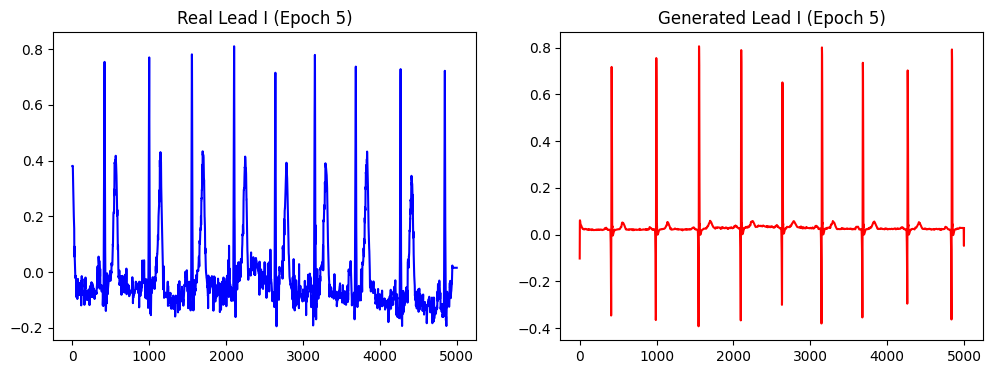

Epoch [6/50] - D Loss: 0.9013, G Loss: 1.1527
Epoch [7/50] - D Loss: 0.9024, G Loss: 1.2607
Epoch [8/50] - D Loss: 0.8363, G Loss: 1.3036
Epoch [9/50] - D Loss: 0.8119, G Loss: 1.3027
Epoch [10/50] - D Loss: 0.8662, G Loss: 1.1229
1/1 [==============================] - 0s 42ms/step


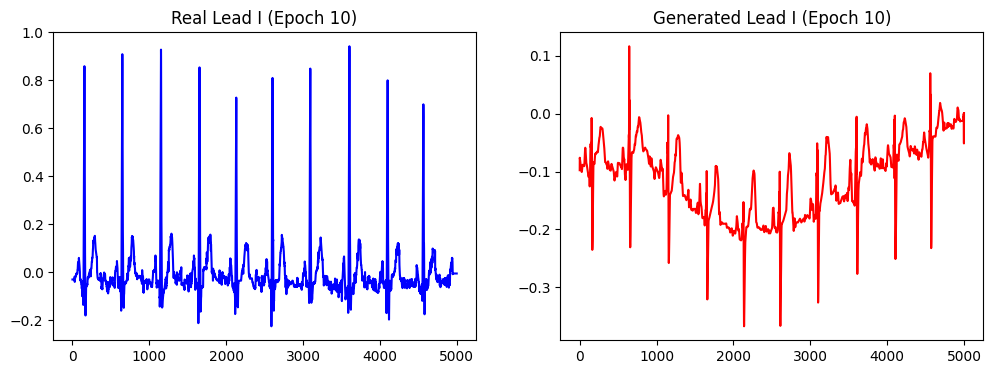

Epoch [11/50] - D Loss: 0.8793, G Loss: 1.2454
Epoch [12/50] - D Loss: 0.9835, G Loss: 1.2081
Epoch [13/50] - D Loss: 1.0399, G Loss: 1.1571
Epoch [14/50] - D Loss: 1.0234, G Loss: 1.1732
Epoch [15/50] - D Loss: 1.0544, G Loss: 1.1136
1/1 [==============================] - 0s 33ms/step


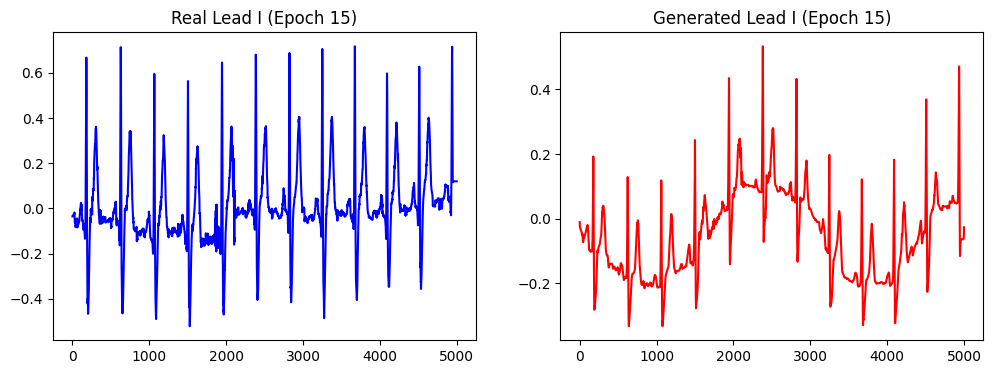

Epoch [16/50] - D Loss: 1.0482, G Loss: 1.1515
Epoch [17/50] - D Loss: 1.0223, G Loss: 1.1371
Epoch [18/50] - D Loss: 1.0433, G Loss: 1.1502
Epoch [19/50] - D Loss: 1.0260, G Loss: 1.0701
Epoch [20/50] - D Loss: 1.0350, G Loss: 1.1453
1/1 [==============================] - 0s 33ms/step


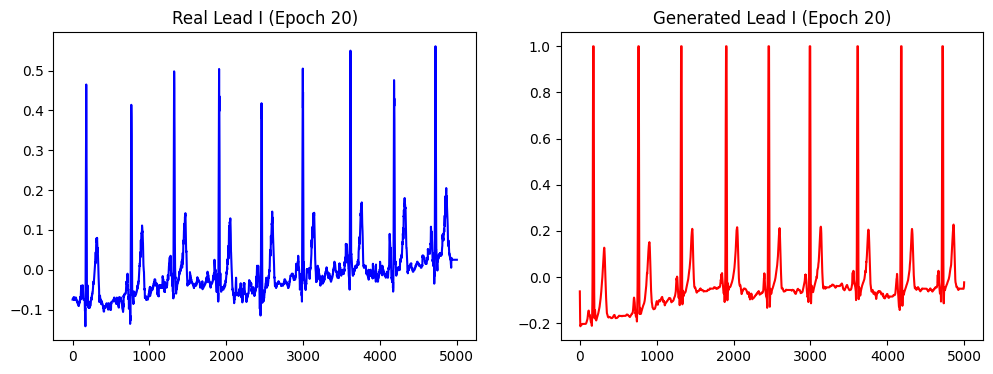

Epoch [21/50] - D Loss: 1.0806, G Loss: 1.0013
Epoch [22/50] - D Loss: 1.1329, G Loss: 1.0054
Epoch [23/50] - D Loss: 1.0782, G Loss: 0.9880
Epoch [24/50] - D Loss: 1.1016, G Loss: 0.9190
Epoch [25/50] - D Loss: 1.0750, G Loss: 1.0314
1/1 [==============================] - 0s 30ms/step


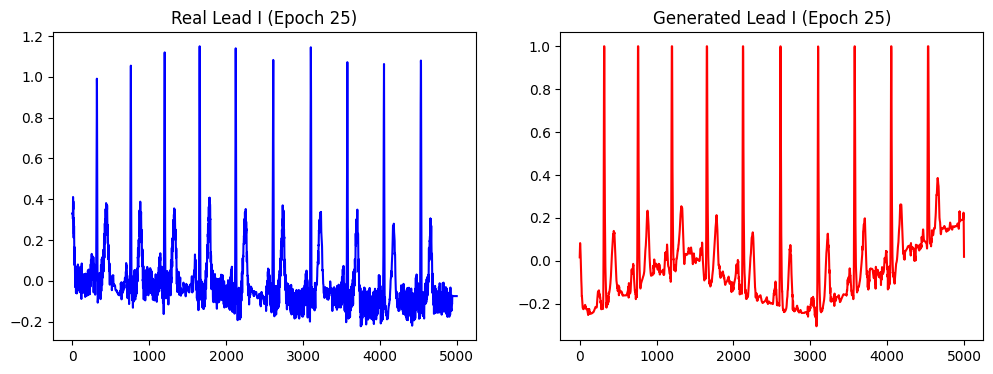

Epoch [26/50] - D Loss: 1.0853, G Loss: 1.0531
Epoch [27/50] - D Loss: 1.0969, G Loss: 0.9699
Epoch [28/50] - D Loss: 1.0692, G Loss: 1.0111
Epoch [29/50] - D Loss: 1.0174, G Loss: 1.0888
Epoch [30/50] - D Loss: 1.0987, G Loss: 0.9897
1/1 [==============================] - 0s 31ms/step


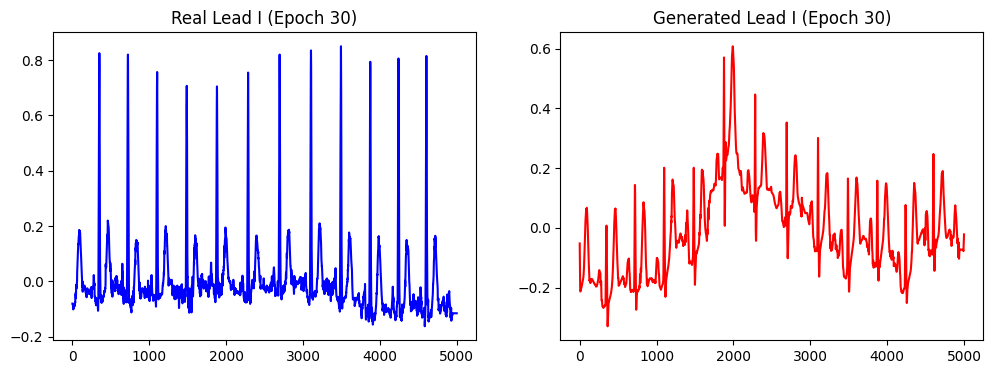

Epoch [31/50] - D Loss: 1.0588, G Loss: 0.9999
Epoch [32/50] - D Loss: 1.1426, G Loss: 0.9764
Epoch [33/50] - D Loss: 1.0967, G Loss: 1.0147
Epoch [34/50] - D Loss: 1.0624, G Loss: 0.9711
Epoch [35/50] - D Loss: 1.0779, G Loss: 1.0283
1/1 [==============================] - 0s 33ms/step


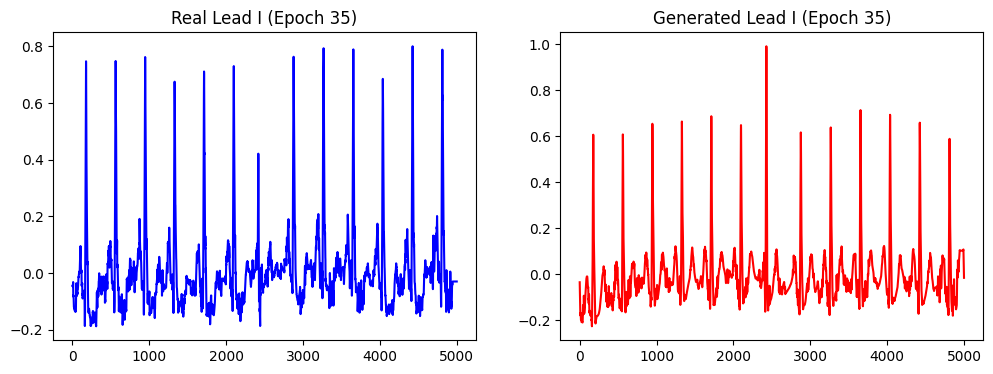

Epoch [36/50] - D Loss: 1.1009, G Loss: 1.0757
Epoch [37/50] - D Loss: 1.0964, G Loss: 1.0681
Epoch [38/50] - D Loss: 1.0774, G Loss: 1.1192
Epoch [39/50] - D Loss: 1.0999, G Loss: 1.0460
Epoch [40/50] - D Loss: 1.0925, G Loss: 1.0098
1/1 [==============================] - 0s 33ms/step


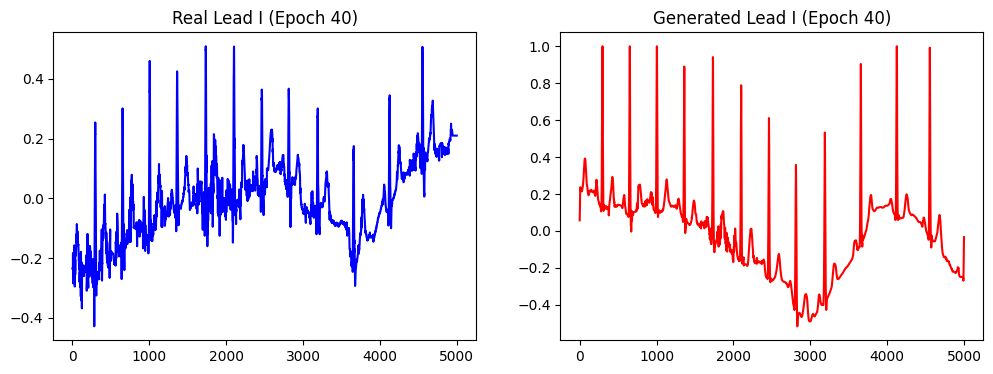

Epoch [41/50] - D Loss: 1.1405, G Loss: 0.9617
Epoch [42/50] - D Loss: 1.0935, G Loss: 1.0775
Epoch [43/50] - D Loss: 1.0503, G Loss: 1.0520
Epoch [44/50] - D Loss: 1.0857, G Loss: 1.0644
Epoch [45/50] - D Loss: 1.1318, G Loss: 0.9648
1/1 [==============================] - 0s 31ms/step


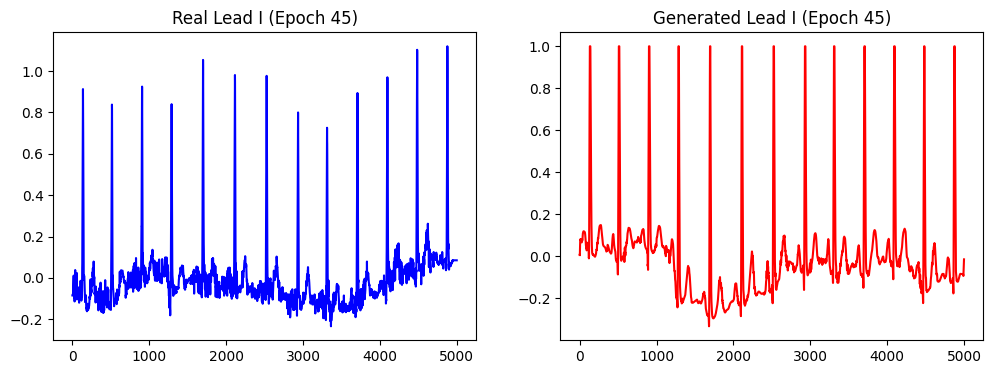

Epoch [46/50] - D Loss: 1.1328, G Loss: 0.9250
Epoch [47/50] - D Loss: 1.2150, G Loss: 0.8808
Epoch [48/50] - D Loss: 1.1727, G Loss: 0.9967
Epoch [49/50] - D Loss: 1.0937, G Loss: 1.0268
Epoch [50/50] - D Loss: 1.0555, G Loss: 1.0622
1/1 [==============================] - 0s 29ms/step


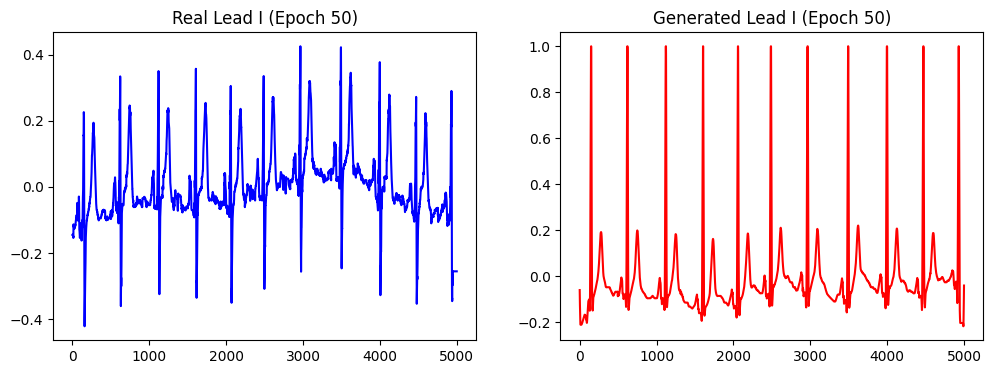

1/1 [==============================] - 0s 31ms/step


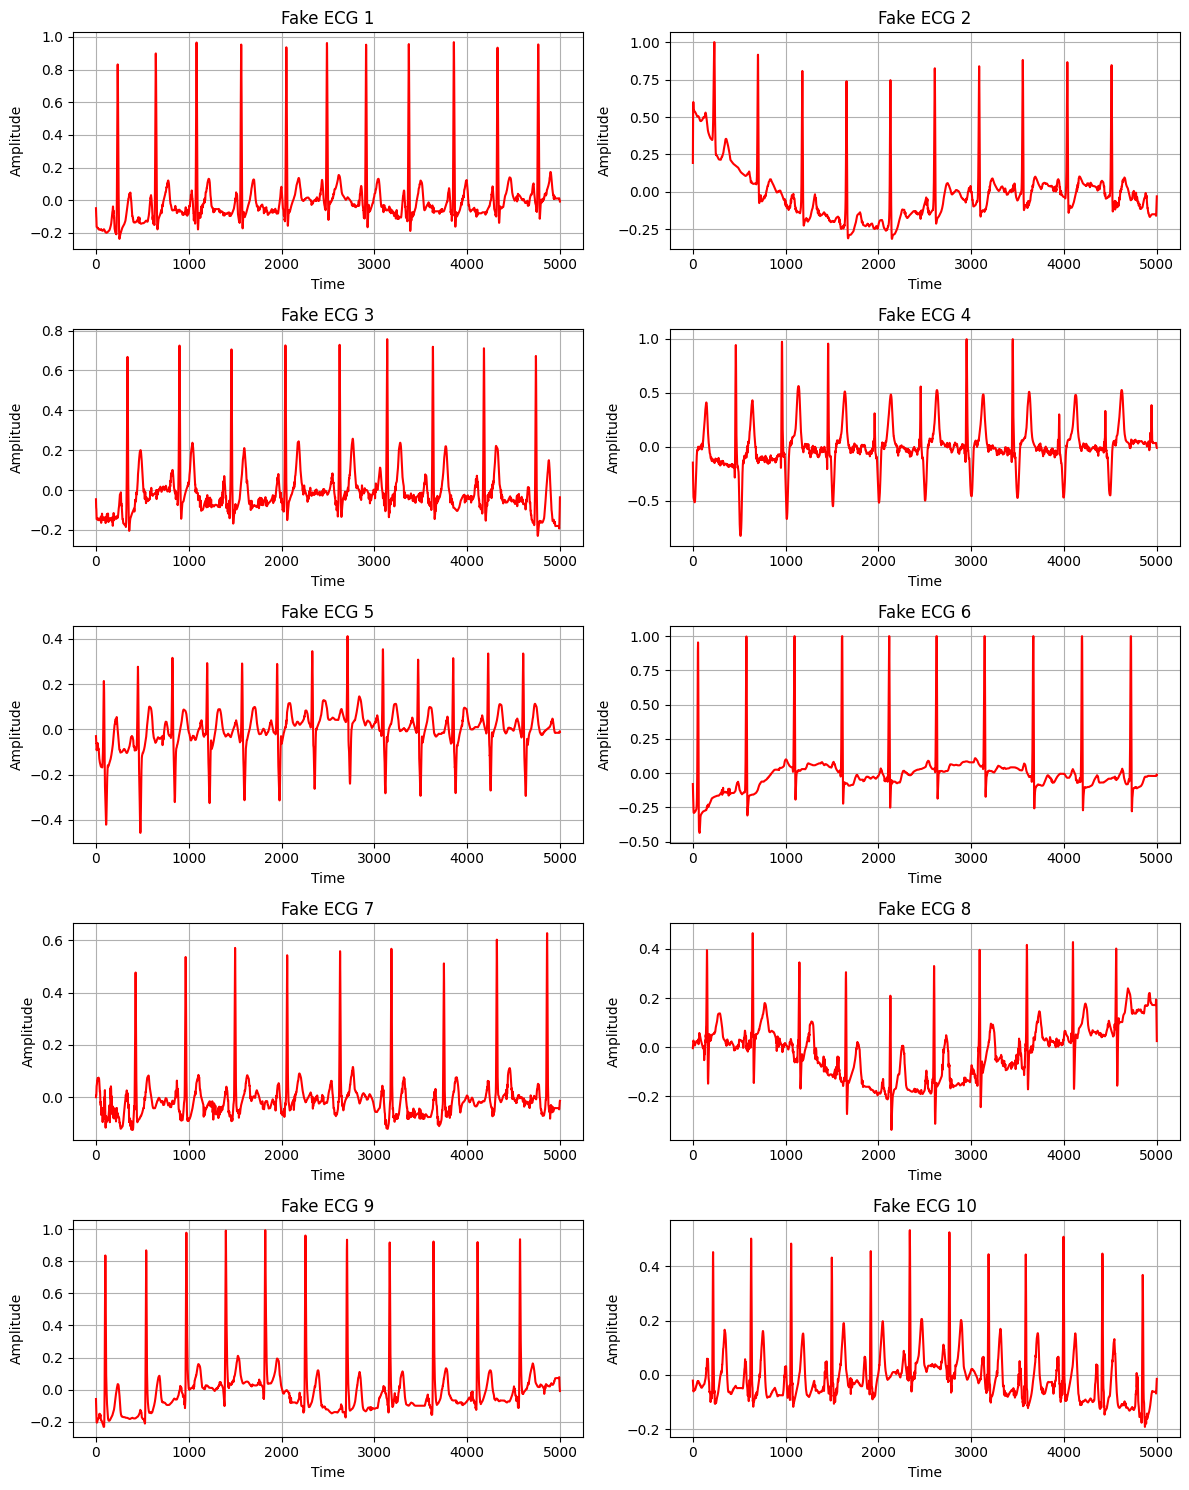

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
import os

# Initialize models
generator = build_simplified_generator(input_shape=(5000, 1))
discriminator = build_simplified_discriminator(input_shape=(5000, 1))

# Optimizers
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Loss functions
bce_loss = BinaryCrossentropy(from_logits=True)
mse_loss = MeanSquaredError()

# Training parameters
epochs = 50
batch_size = 32
real_label = 0.9
fake_label = 0.1

# Reshape the data
lead_I_scaled = np.expand_dims(lead_I_data, axis=-1)
lead_II_scaled = np.expand_dims(lead_II_data, axis=-1)

# Training loop
for epoch in range(epochs):
    for i in range(0, len(lead_II_scaled), batch_size):
        input_batch = lead_II_scaled[i:i + batch_size]
        real_lead_I_batch = lead_I_scaled[i:i + batch_size]
        batch_size_actual = input_batch.shape[0]

        # Train Discriminator
        with tf.GradientTape() as d_tape:
            fake_lead_I = generator(input_batch, training=True)
            real_preds = discriminator(real_lead_I_batch, training=True)
            fake_preds = discriminator(fake_lead_I, training=True)

            real_targets = tf.ones((batch_size_actual, 1)) * real_label
            fake_targets = tf.ones((batch_size_actual, 1)) * fake_label

            d_loss_real = bce_loss(real_targets, real_preds)
            d_loss_fake = bce_loss(fake_targets, fake_preds)
            d_loss = d_loss_real + d_loss_fake

        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as g_tape:
            fake_lead_I = generator(input_batch, training=True)
            fake_preds = discriminator(fake_lead_I, training=True)

            g_adv_loss = bce_loss(real_targets, fake_preds)
            g_recon_loss = mse_loss(real_lead_I_batch, fake_lead_I)

            g_loss = g_adv_loss + g_recon_loss

        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    print(f"Epoch [{epoch + 1}/{epochs}] - D Loss: {d_loss.numpy():.4f}, G Loss: {g_loss.numpy():.4f}")

    # Plot every 5 epochs
    if (epoch + 1) % 5 == 0:
        random_idx = np.random.randint(0, len(lead_II_scaled))
        real_sample = lead_I_scaled[random_idx]
        input_sample = lead_II_scaled[random_idx]
        input_sample = np.expand_dims(input_sample, axis=0)
        fake_sample = generator.predict(input_sample)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(real_sample[:, 0], color='blue')
        plt.title(f"Real Lead I (Epoch {epoch + 1})")

        plt.subplot(1, 2, 2)
        plt.plot(fake_sample[0, :, 0], color='red')
        plt.title(f"Generated Lead I (Epoch {epoch + 1})")
        plt.show()

# Generate 10 fake ECGs and save as .asc files
save_path = "C:/Users/M2-Winterfell/Downloads/Dissertation/results"
os.makedirs(save_path, exist_ok=True)

# Generate and plot 10 fake ECG signals
plt.figure(figsize=(12, 15))

for i in range(10):
    random_idx = np.random.randint(0, len(lead_II_scaled))
    input_sample = np.expand_dims(lead_II_scaled[random_idx], axis=0)
    fake_signal = generator.predict(input_sample)[0, :, 0]

    np.savetxt(os.path.join(save_path, f"fake_ecg_{i+1}.asc"), fake_signal)
    # Plot the generated ECG signal
    plt.subplot(5, 2, i + 1)  # 5 rows, 2 columns (for 10 plots)
    plt.plot(fake_signal, color='red')
    plt.title(f"Fake ECG {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display all generated ECGs